In [ ]:
# default_exp models.esrnn.esrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# ES-RNN: Exponential Smoothing Recurrent Neural Network

> API details.
- https://www.sciencedirect.com/science/article/pii/S0169207019301153
- https://github.com/Mcompetitions/M4-methods/tree/master/118%20-%20slaweks17

In [ ]:
#export
import os
import random
import time
from collections import defaultdict
from copy import deepcopy
from pathlib import Path

import numpy as np
import pandas as pd
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from nixtla.models.esrnn.esrnn_model import _ESRNN
from nixtla.losses.pytorch import (
    MAPELoss, MASELoss, SMAPELoss, 
    MSELoss, MAELoss, SmylLoss, 
    PinballLoss, MQLoss, wMQLoss 
)
from nixtla.losses.numpy import (
    mae, mse, mape, 
    smape, rmse, 
    pinball_loss, mqloss, wmqloss
)

In [ ]:
#export
#TODO: eval_mode=False
#TODO: cambiar por similar a Nbeats
#TODO: hacer que todo el modelo opere con mascaras: loss, forward, loader. deshackear sample mask, filtro de forward
class ESRNN(object):
    """ Exponential Smoothing Recurrent Neural Network

    Pytorch Implementation of the M4 time series forecasting competition winner.
    Proposed by Smyl. The model uses a hybrid approach of Machine Learning and
    statistical methods by combining recurrent neural networks to model a common
    trend with shared parameters across series, and multiplicative Holt-Winter
    exponential smoothing.

    Parameters
    ----------
    max_epochs: int
        maximum number of complete passes to train data during fit
    learning_rate: float
        size of the stochastic gradient descent steps
    lr_scheduler_step_size: int
        this step_size is the period for each learning rate decay
    per_series_lr_multip: float
        multiplier for per-series parameters smoothing and initial
        seasonalities learning rate (default 1.0)
    gradient_eps: float
        term added to the Adam optimizer denominator to improve
        numerical stability (default: 1e-8)
    gradient_clipping_threshold: float
        max norm of gradient vector, with all parameters treated
        as a single vector
    rnn_weight_decay: float
        parameter to control classic L2/Tikhonov regularization
        of the rnn parameters
    noise_std: float
        standard deviation of white noise added to input during
        fit to avoid the model from memorizing the train data
    level_variability_penalty: float
        this parameter controls the strength of the penalization
        to the wigglines of the level vector, induces smoothness
        in the output
    testing_percentile: float
        This value is only for diagnostic evaluation.
        In case of percentile predictions this parameter controls
        for the value predicted, when forecasting point value,
        the forecast is the median, so percentile=50.
    training_percentile: float
        To reduce the model's tendency to over estimate, the
        training_percentile can be set to fit a smaller value
        through the Pinball Loss.
    seasonality: int list
        list of seasonalities of the time series
        Hourly [24, 168], Daily [7], Weekly [52], Monthly [12],
        Quarterly [4], Yearly [].
    input_size: int
        input size of the recurrent neural network, usually a
        multiple of seasonality
    output_size: int
        output_size or forecast horizon of the recurrent neural
        network, usually multiple of seasonality
    random_seed: int
        random_seed for pseudo random pytorch initializer and
        numpy random generator
    min_inp_seq_length: int
        description
    cell_type: str
        Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
    state_hsize: int
        dimension of hidden state of the recurrent neural network
    dilations: int list
        each list represents one chunk of Dilated LSTMS, connected in
        standard ResNet fashion
    add_nl_layer: bool
        whether to insert a tanh() layer between the RNN stack and the
        linear adaptor (output) layers
    device: str
        pytorch device either 'cpu' or 'cuda'
    Notes
    -----
    **References:**
    `M4 Competition Conclusions
    <https://rpubs.com/fotpetr/m4competition>`__
    `Original Dynet Implementation of ESRNN
    <https://github.com/M4Competition/M4-methods/tree/master/118%20-%20slaweks17>`__
    """
    def __init__(self,
                 input_size,
                 output_size,
                 es_component,
                 cell_type,
                 state_hsize,
                 dilations,
                 add_nl_layer,
                 seasonality,
                 learning_rate,
                 lr_scheduler_step_size,
                 lr_decay,
                 per_series_lr_multip,
                 gradient_eps,
                 gradient_clipping_threshold,
                 rnn_weight_decay,
                 n_iterations,
                 early_stopping,
                 noise_std,
                 level_variability_penalty,
                 testing_percentile,
                 training_percentile,
                 loss,
                 val_loss,
                 random_seed,
                 device=None,
                 root_dir='./'):
        super(ESRNN, self).__init__()
        
        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.es_component = es_component
        self.cell_type = cell_type
        self.state_hsize = state_hsize
        self.dilations = dilations
        self.add_nl_layer = add_nl_layer
        self.seasonality = seasonality

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_scheduler_step_size = lr_scheduler_step_size
        self.lr_decay = lr_decay
        self.per_series_lr_multip = per_series_lr_multip
        self.gradient_eps = gradient_eps
        self.gradient_clipping_threshold = gradient_clipping_threshold
        self.rnn_weight_decay = rnn_weight_decay
        self.noise_std = noise_std
        self.level_variability_penalty = level_variability_penalty
        self.testing_percentile = testing_percentile
        self.training_percentile = training_percentile
        self.loss = loss
        self.val_loss = val_loss
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping        
        self.random_seed = random_seed
        
        # MQESRNN
        self.mq = isinstance(self.training_percentile, list)
        self.output_size_m = len(self.training_percentile) if self.mq else 1
        
        self.device = device or 'cuda' if t.cuda.is_available() else 'cpu'

        self.root_dir = root_dir
        self._fitted = False

    def to_tensor(self, x: np.ndarray, dtype = t.float32) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=dtype).to(self.device)
        return tensor

    def __loss_fn(self, loss_name: str):
        #TODO: replace with kwargs
        def loss(x, forecast, target, mask, levels):
            if loss_name == 'SMYL':
                return SmylLoss(y=target, y_hat=forecast, levels=levels, mask=mask,
                                tau=(self.training_percentile / 100),
                                level_variability_penalty=self.level_variability_penalty)
            elif loss_name == 'MQ':
                quantiles = [tau / 100 for tau in self.training_percentile]
                quantiles = self.to_tensor(np.array(quantiles))
                return MQLoss(y=target, y_hat=forecast, quantiles=quantiles, mask=mask)
            elif loss_name == 'wMQ':
                quantiles = [tau / 100 for tau in self.training_percentile]
                quantiles = self.to_tensor(np.array(quantiles))
                return wMQLoss(y=target, y_hat=forecast, quantiles=quantiles, mask=mask)
            elif loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask)
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, 
                                   tau=(self.training_percentile/100))
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def __val_loss_fn(self, loss_name='MAE'):
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MQ':
                quantiles = [tau / 100 for tau in self.testing_percentile]
                quantiles = np.array(quantiles)
                return mqloss(y=target, y_hat=forecast, quantiles=quantiles, weights=weights)
            elif loss_name == 'wMQ':
                quantiles = [tau / 100 for tau in self.training_percentile]
                quantiles = np.array(quantiles)
                return wmqloss(y=target, y_hat=forecast, quantiles=quantiles, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, 
                                    tau=(self.testing_percentile/100))
            else:
                raise Exception(f'Unknown loss function: {loss_name}')

        return loss
            

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_freq=1):
        """
        Fit ESRNN model.

        Parameters
        ----------
        Returns
        -------
        self : returns an instance of self.
        """

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Exogenous variables
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()
        self.frequency = train_ts_loader.get_frequency()
        
        #if verbose: print("Infered frequency: {}".format(self.frequency))

        # Initialize model
        self.n_series = train_ts_loader.get_n_series()
        self.model = _ESRNN(n_series=self.n_series, 
                            input_size=self.input_size,
                            output_size=self.output_size, 
                            output_size_m=self.output_size_m,
                            n_t=self.n_x_t, n_s=self.n_x_s,
                            es_component=self.es_component, 
                            seasonality=self.seasonality,
                            noise_std=self.noise_std, 
                            cell_type=self.cell_type,
                            dilations=self.dilations, 
                            state_hsize=self.state_hsize,
                            add_nl_layer=self.add_nl_layer, 
                            device=self.device).to(self.device)

        # Train model
        self._fitted = True

        # Optimizers
        self.es_optimizer = optim.Adam(params=self.model.es.parameters(),
                                       lr=self.learning_rate * self.per_series_lr_multip,
                                       betas=(0.9, 0.999), 
                                       eps=self.gradient_eps)

        self.es_scheduler = StepLR(optimizer=self.es_optimizer,
                                    step_size=self.lr_scheduler_step_size,
                                    gamma=0.9)

        self.rnn_optimizer = optim.Adam(params=self.model.rnn.parameters(),
                                        lr=self.learning_rate,
                                        betas=(0.9, 0.999), 
                                        eps=self.gradient_eps,
                                        weight_decay=self.rnn_weight_decay)

        self.rnn_scheduler = StepLR(optimizer=self.rnn_optimizer,
                                    step_size=self.lr_scheduler_step_size,
                                    gamma=self.lr_decay)

        # Loss Functions
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses
                
        if verbose:
            print('\n')
            print('='*30+' Start fitting '+'='*30)

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        start = time.time()
        self.trajectories = {'iteration':[], 'train_loss':[], 'val_loss':[]}

        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_insample_loss = np.inf
        best_state_dict = deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue
                
                self.model.train()
                self.es_optimizer.zero_grad()
                self.rnn_optimizer.zero_grad()
                
                # Parse batch
                S  = self.to_tensor(x=batch['S'])
                Y  = self.to_tensor(x=batch['Y'])
                X  = self.to_tensor(x=batch['X'])
                idxs = self.to_tensor(x=batch['idxs'], dtype=t.long)

                outsample_y, forecast, levels = self.model(S=S, Y=Y, X=X, idxs=idxs,
                                                           step_size=train_ts_loader.idx_to_sample_freq)
                
                outsample_mask = self.to_tensor(t.ones(forecast.shape))
                
                # train loss on normalized values
                training_loss = training_loss_fn(x=Y, # TODO: eliminate only useful for MASE 
                                                 forecast=forecast,
                                                 target=outsample_y,
                                                 mask=outsample_mask, levels=levels)                
                
                # Protection to exploding gradients
                training_loss.backward()
                t.nn.utils.clip_grad_norm_(parameters=self.model.rnn.parameters(),
                                           max_norm=self.gradient_clipping_threshold)
                t.nn.utils.clip_grad_norm_(parameters=self.model.es.parameters(),
                                           max_norm=self.gradient_clipping_threshold)
                self.rnn_optimizer.step()
                self.es_optimizer.step()

            # Decay learning rate
            self.es_scheduler.step()
            self.rnn_scheduler.step()

            # Evaluation
            if (iteration % eval_freq == 0):
                #print("EVALUATION")
                display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                        time.time()-start,
                                                                                        self.loss,
                                                                                        training_loss.cpu().data.numpy())
                self.trajectories['iteration'].append(iteration)
                self.trajectories['train_loss'].append(float(training_loss.cpu().data.numpy()))

                if val_ts_loader is not None:
                    loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                     validation_loss_fn=validation_loss_fn)
                    display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                    self.trajectories['val_loss'].append(loss)

                    if self.early_stopping:
                        if loss < best_val_loss:
                            # Save current model if improves outsample loss
                            best_state_dict = deepcopy(self.model.state_dict())
                            best_insample_loss = training_loss.cpu().data.numpy()
                            early_stopping_counter = 0
                            best_val_loss = loss
                        else:
                            early_stopping_counter += 1
                        if early_stopping_counter >= self.early_stopping:
                            break_flag = True

                print(display_string)
        
                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations > 0:
            # This is batch loss!
            self.final_insample_loss = float(training_loss.cpu().data.numpy()) if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, return_decomposition=False):
        assert self._fitted, "Model not fitted yet"
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        outsample_ys = []

        with t.no_grad():
            outsample_ys = []
            forecasts = []
            for batch in iter(ts_loader):
                # Parse batch
                S  = self.to_tensor(x=batch['S'])
                Y  = self.to_tensor(x=batch['Y'])
                X  = self.to_tensor(x=batch['X'])
                idxs = self.to_tensor(x=batch['idxs'], dtype=t.long)
                
                #print("insample_y.shape", insample_y.shape)
                
                outsample_y, forecast = self.model.predict(S=S, Y=Y, X=X, idxs=idxs,
                                                           step_size=ts_loader.idx_to_sample_freq)
                
                #print("outsample_y.shape", outsample_y.shape)
                #print("forecast.shape", forecast.shape)
                
                # Parsing rolled forecasts, 
                # keeping only last available forecast per window
                outsample_y = outsample_y[:, -1, :]
                forecast = forecast[:, -1, :]
                
                outsample_ys.append(outsample_y.cpu().data.numpy())
                forecasts.append(forecast.cpu().data.numpy())
        
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.ones(outsample_ys.shape)
        
        self.model.train()

        if return_decomposition:
            return #TODO
        else:
            return outsample_ys, forecasts, outsample_masks
        
    def forecast(self, Y_df, X_df, f_cols):
        # TODO: protect available_mask from nans
        # Last output_size mask for predictions
        mask_df = Y_df.copy()
        mask_df = mask_df[['unique_id', 'ds']]
        sample_mask = np.ones(len(mask_df))
        mask_df['sample_mask'] = np.ones(len(mask_df))
        mask_df['available_mask'] = np.ones(len(mask_df))
        
        # Model inputs
        ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, 
                                       mask_df=mask_df, f_cols=f_cols, verbose=False)
        
        ts_loader = TimeSeriesLoader(model='new_rnn',
                                     ts_dataset=ts_dataset,
                                     window_sampling_limit=500_000,
                                     input_size=self.input_size,
                                     output_size=self.output_size,
                                     idx_to_sample_freq=self.output_size,
                                     batch_size=1024,
                                     complete_inputs=False,
                                     complete_sample=True,
                                     shuffle=False)
            
        y_true, y_hat, _ = self.predict(ts_loader=ts_loader, 
                                        return_decomposition=False)
        
        # Reshaping model outputs
        y_true = y_true.reshape(-1)
        y_hat  = y_hat.reshape(-1)
        
        Y_hat_df = pd.DataFrame({'unique_id': Y_df.unique_id.values[self.input_size:],
                                 'ds': Y_df.ds.values[self.input_size:],
                                 'y': Y_df.y.values[self.input_size:],
                                 'y_hat': y_hat})

        Y_hat_df['residual'] = Y_hat_df['y'] - Y_hat_df['y_hat']            
        return Y_hat_df
    
    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        target, forecast, outsample_mask = self.predict(ts_loader=ts_loader)

        #complete_loss = validation_loss_fn(target=target, forecast=forecast, weights=outsample_mask)
        complete_loss = validation_loss_fn(target=target, forecast=forecast, weights=None)

        self.model.train()

        return complete_loss    

    def save(self, model_dir=None, copy=None):
        """Auxiliary function to save ESRNN model"""
        if copy is not None:
                self.copy = copy

        if not model_dir:
            assert self.root_dir
            model_dir = self.get_dir_name()

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        rnn_filepath = os.path.join(model_dir, "rnn.model")
        es_filepath = os.path.join(model_dir, "es.model")

        print('Saving model to:\n {}'.format(model_dir)+'\n')
        t.save({'model_state_dict': self.es.state_dict()}, es_filepath)
        t.save({'model_state_dict': self.rnn.state_dict()}, rnn_filepath)

    def load(self, model_dir=None, copy=None):
        """Auxiliary function to load ESRNN model"""
        if copy is not None:
            self.copy = copy

        if not model_dir:
            assert self.root_dir
            model_dir = self.get_dir_name()

        rnn_filepath = os.path.join(model_dir, "rnn.model")
        es_filepath = os.path.join(model_dir, "es.model")
        path = Path(es_filepath)

        if path.is_file():
            print('Loading model from:\n {}'.format(model_dir)+'\n')

            checkpoint = t.load(es_filepath, map_location=self.device)
            self.es.load_state_dict(checkpoint['model_state_dict'])
            self.es.to(self.device)

            checkpoint = t.load(rnn_filepath, map_location=self.device)
            self.rnn.load_state_dict(checkpoint['model_state_dict'])
            self.rnn.to(self.device)
        else:
            print('Model path {} does not exist'.format(path))


## EPF dataset

In [ ]:
import matplotlib.pyplot as plt

from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

In [ ]:
Y_df, X_df, _ = EPF.load(directory='../data', group=EPFInfo.groups[0])

X_df = X_df[['unique_id', 'ds', 'week_day']]

# Leveling Y_df (multiplicative model)
Y_min = Y_df.y.min()
Y_df.y = Y_df.y - Y_min + 20

train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
                                     ds_in_test=728*24, verbose=True)

outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
                                         ds_in_test=728*24, is_test=True, verbose=True)

train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                   #model='esrnn',
                                   model='new_rnn',
                                   #model='esrnn',
                                   #window_sampling_limit= 28*24,
                                   window_sampling_limit= 500_000, # To limit backprop time
                                   input_size=7*24,
                                   output_size=24,
                                   idx_to_sample_freq=24,
                                   len_sample_chunks=3*7*24,
                                   complete_inputs=True,
                                   complete_sample=False,
                                   batch_size=32,
                                   shuffle=True)

val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                 model='new_rnn',
                                 #model='esrnn',
                                 window_sampling_limit= 500_000, 
                                 input_size=7*24,
                                 output_size=24,
                                 idx_to_sample_freq=24,
                                 len_sample_chunks=4*7*24,
                                 complete_inputs=False,
                                 complete_sample=True,
                                 batch_size=1,
                                 shuffle=False)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=66.67, 	34944.0 time stamps 
Outsample percentage=33.33, 	17472.0 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=33.33, 	17472.0 time stamps 
Outsample percentage=66.67, 	34944.0 time sta

In [ ]:
model = ESRNN(# Architecture parameters
              input_size=5*24,
              output_size=24,
              es_component='multiplicative',
              cell_type='LSTM',
              state_hsize=50,
              dilations=[[1, 2], [7, 14]],
              add_nl_layer=False,
              # Regularization and optimization parameters
              n_iterations=5,#_000,
              early_stopping=20,
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              loss='SMYL',
              #loss='PINBALL',
              val_loss='MAE',
              #seasonality=[24, 168],
              seasonality=[24],
              random_seed=2) #RNN, GRU, LSTM, RNN, ResidualLSTM

In [ ]:
model.fit(train_ts_loader=train_ts_loader, 
          val_ts_loader=val_ts_loader,
          eval_freq=10)



============================== Start fitting ==============================
Step: 5, Time: 2.181, Insample SMYL: 0.03181, Outsample MAE: 3.63328
==============================  End fitting  ==============================




In [ ]:
# y_true, y_hat, y_mask = model.predict(ts_loader=val_ts_loader)
Y_hat_df = model.forecast(Y_df=Y_df, X_df=X_df, f_cols=[])

# Returning level to Y_df and Y_hat_df
Y_df.y = Y_df.y + Y_min - 20
Y_hat_df.y = Y_hat_df.y + Y_min - 20
Y_hat_df.y_hat = Y_hat_df.y_hat + Y_min - 20

Y_hat_df.to_csv(f'./results/{Y_df.unique_id[0]}_esrnn_predictions.csv', index=False)

In [ ]:
from nixtla.losses.numpy import mae, rmae, smape, rmse
from nixtla.data.datasets.epf import epf_naive_forecast
from scipy import stats

Y_naive_df = epf_naive_forecast(Y_df)

y_true = Y_hat_df.y.values[-728*24:]
y_hat = Y_hat_df.y_hat.values[-728*24:]
y_naive = Y_naive_df.y_hat[-728*24:]

print("Original")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
y_true = y_true.flatten()
y_hat = y_hat.flatten()
print("\nFlatten")
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
print("y_naive.shape", y_naive.shape)

metrics = pd.Series({'mae' : mae(y=y_true, y_hat=y_hat),
                     'rmae': rmae(y=y_true, y_hat1=y_hat, y_hat2=y_naive),
                     'smape': smape(y=y_true, y_hat=y_hat),
                     'rmse': rmse(y=y_true, y_hat=y_hat)})

print(Y_df.unique_id[0])
print(metrics)
print('\n')
print(stats.describe(y_true-y_hat))
print(f'model.training_percentile {model.training_percentile}')

Original
y_true.shape (17472,)
y_hat.shape (17472,)

Flatten
y_true.shape (17472,)
y_hat.shape (17472,)
y_naive.shape (17472,)
NP
mae      3.389057
rmae     1.070846
smape    9.573303
rmse     5.253447
dtype: float64


DescribeResult(nobs=17472, minmax=(-37.903439636230466, 157.06744674682616), mean=-0.4110529090414992, variance=27.4313128843282, skewness=3.37838987801879, kurtosis=63.848421167002186)
model.training_percentile 51


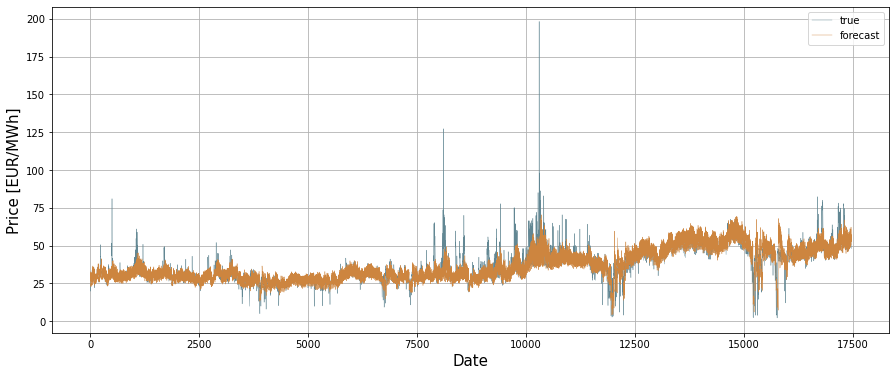

In [ ]:
start = 0
end = 728 * 24

# start = 365
# end = 365 + (4*7*24)

fig = plt.figure(figsize=(15, 6))
plt.plot(y_true[start:end], color='#628793', linewidth=0.4, label='true')
plt.plot(y_hat[start:end], color='peru', linewidth=0.4, label='forecast')
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.grid()
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()

# Tourism dataset

In [ ]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo
print(TourismInfo.groups[0])
Y_df, *_ = Tourism.load(directory='../data', group=TourismInfo.groups[0])

Yearly


In [ ]:
train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, mask_df=None, ds_in_test=6)

In [ ]:
train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                   #model='esrnn',
                                   model='new_rnn',
                                   #model='esrnn',
                                   #window_sampling_limit= 28*24,
                                   window_sampling_limit= 500_000, # To limit backprop time
                                   input_size=6 * 2,
                                   output_size=6,
                                   idx_to_sample_freq=1,
                                   len_sample_chunks=6 * 3,
                                   complete_inputs=True,
                                   complete_sample=False,
                                   batch_size=32,
                                   shuffle=True)

val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                 model='new_rnn',
                                 #model='esrnn',
                                 window_sampling_limit= 500_000, 
                                 input_size=6 * 2,
                                 output_size=6,
                                 idx_to_sample_freq=1,
                                 len_sample_chunks=6 * 3,
                                 complete_inputs=False,
                                 complete_sample=True,
                                 batch_size=1,
                                 shuffle=False)

In [ ]:
dataloader = iter(train_ts_loader)
batch = next(dataloader)
S, Y, X = batch['S'], batch['Y'], batch['X']
available_mask = batch['available_mask']
idxs = batch['idxs']

print("S.shape", S.shape)
print("Y.shape", Y.shape)
print("X.shape", X.shape)
print("idxs.shape", idxs.shape)

S.shape (32, 0)
Y.shape torch.Size([32, 18])
X.shape torch.Size([32, 0, 18])
idxs.shape (32,)


In [ ]:
model = ESRNN(input_size=6 * 2,
              output_size=6,
              learning_rate=5e-3,
              lr_scheduler_step_size=100,
              lr_decay=0.9,
              per_series_lr_multip=1.5,
              gradient_eps=1e-8,
              gradient_clipping_threshold=10,
              rnn_weight_decay=0,
              n_iterations=10,#00,#00,
              early_stopping=20,
              noise_std=0.001,
              level_variability_penalty=10,
              testing_percentile=50,
              training_percentile=51,
              es_component='multiplicative',
              cell_type='GRU',
              state_hsize=50,
              dilations=[[24, 48], [168]],
              add_nl_layer=False,
              loss='SMYL',
              #loss='PINBALL',
              val_loss='MAE',
              #seasonality=[24, 168],
              seasonality=[1],
              random_seed=1) #RNN, GRU, LSTM, RNN, ResidualLSTM

In [ ]:
model.fit(train_ts_loader=train_ts_loader, 
          val_ts_loader=val_ts_loader, 
          #val_ts_loader=val_ts_loader, 
          eval_freq=10)



============================== Start fitting ==============================
Step: 17, Time: 1.198, Insample SMYL: 0.33718, Outsample MAE: 5.26788
==============================  End fitting  ==============================




In [ ]:
y_true, y_hat, y_mask = model.predict(ts_loader=val_ts_loader)
print("y_true.shape", y_true.shape)
print("y_hat.shape", y_hat.shape)
print("y_mask.shape", y_mask.shape)

y_true.shape (17467, 6)
y_hat.shape (17467, 6)
y_mask.shape (17467, 6)
